In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from IPython.display import Image
from subprocess import call

All Data: 1217
Train Data: 1167
Test Data: 50


<Axes: >

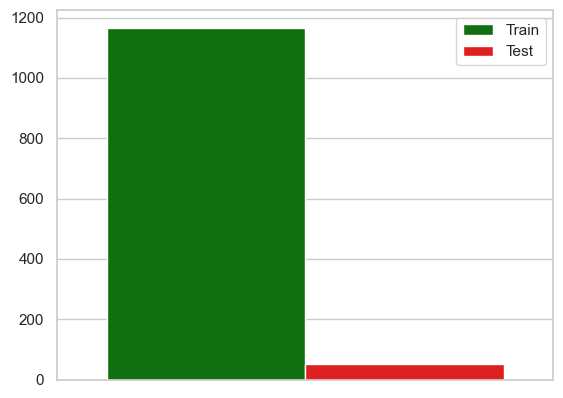

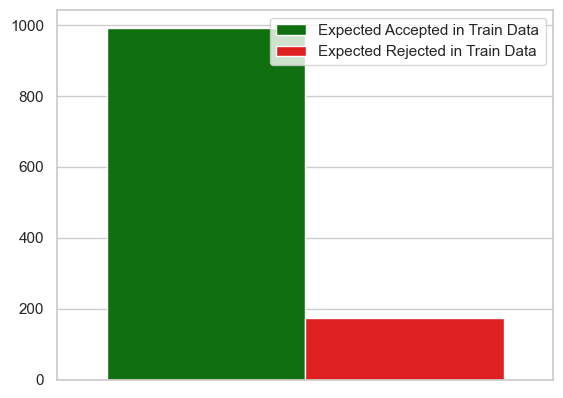

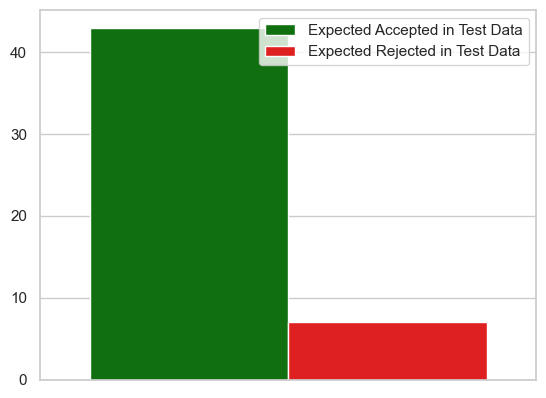

In [2]:
with open("../../data/training/train.json", "r", encoding="utf-8") as fp:
    train_reviews = json.load(fp)

with open("../../data/training/test.json", "r", encoding="utf-8") as fp:
    test_reviews = json.load(fp)


print(f"All Data: {len(train_reviews) + len(test_reviews)}")
print(f"Train Data: {len(train_reviews)}")
print(f"Test Data: {len(test_reviews)}")


sns.set_theme(style="whitegrid")

plt.figure()
sns.barplot(hue=["Train", "Test"], y=[len(train_reviews), len(test_reviews)], palette=["green", "red"])

plt.figure()
sns.barplot(hue=["Expected Accepted in Train Data", "Expected Rejected in Train Data"], y=[len([r for r in train_reviews if bool(r["conclusion"])]), len([r for r in train_reviews if not bool(r["conclusion"])])], palette=["green", "red"])

plt.figure()
sns.barplot(hue=["Expected Accepted in Test Data", "Expected Rejected in Test Data"], y=[len([r for r in test_reviews if bool(r["conclusion"])]), len([r for r in test_reviews if not bool(r["conclusion"])])], palette=["green", "red"])

In [3]:
def createDataFrame(file):
    ratings = [review['rating'] for review in file]
    conclusions = [review['conclusion'] for review in file]
    df = pd.DataFrame({'rating': ratings, 'conclusion': conclusions})

    ratingAttr = ['Accuracy', 'Objectivity', 'Clarity and Coherence', 'Depth of Analysis', 'Language and Presentation', 'Readability', 'Attractiveness']
    for i in range(7):
        df[ratingAttr[i]] = df['rating'].apply(lambda x: x[i])
    df.drop('rating', axis=1, inplace=True)
    return df

train_df = createDataFrame(train_reviews)
test_df = createDataFrame(test_reviews)

X_train = train_df.drop('conclusion', axis=1)
y_train = train_df['conclusion']
X_test = test_df.drop('conclusion', axis=1)
y_test = test_df['conclusion']

display(X_train.head(5))
display(y_train.head(5))

,Accuracy,Objectivity,Clarity and Coherence,Depth of Analysis,Language and Presentation,Readability,Attractiveness
0,3,3,4,4,5,4,3
1,7,8,7,6,9,8,8
2,5,7,6,4,7,6,6
3,7,5,8,6,7,8,7
4,7,7,8,6,8,7,6


0    0
1    1
2    1
3    1
4    1
Name: conclusion, dtype: int64

In [4]:
forest = RandomForestClassifier(n_estimators=50, random_state=42)
print("Training started")
forest.fit(X_train, y_train)
print("Training finished")
print("Validation started")
scores = cross_val_score(forest, X_train, y_train, cv=10, scoring='accuracy')
print("Validation finished")
print(f"Accuracy scores for each fold are: {scores}")
print(f"Mean cross-validation score (Accuracy): {np.mean(scores):.4f}")
print(f"Standard deviation of cross-validation scores: {np.std(scores):.4f}")

Training started
Training finished
Validation started
Validation finished
Accuracy scores for each fold are: [0.97435897 0.94871795 0.94017094 0.97435897 0.8974359  0.95726496
 0.97435897 0.98275862 0.93965517 0.92241379]
Mean cross-validation score (Accuracy): 0.9511
Standard deviation of cross-validation scores: 0.0257


In [5]:
y_pred = forest.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print(f"Test ROC AUC Score: {roc_auc_score(y_test, y_pred):.4f}")

Accuracy: 96.00%
Test ROC AUC Score: 0.9169


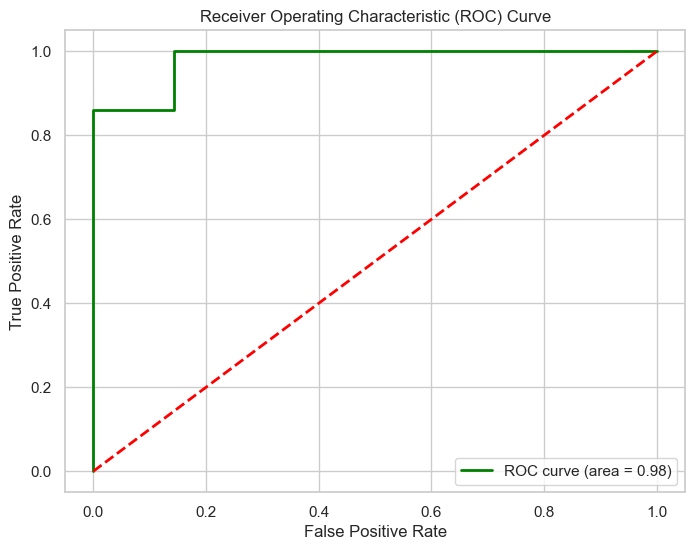

In [6]:
y_pred_prob = forest.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [7]:
fi_model = pd.DataFrame({'feature': X_train.columns,
                   'importance': forest.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_model.head(7)

,feature,importance
0,Accuracy,0.311027
6,Attractiveness,0.198267
5,Readability,0.181165
2,Clarity and Coherence,0.149403
1,Objectivity,0.061084
3,Depth of Analysis,0.058693
4,Language and Presentation,0.040361
